In [1]:
import numpy as np # linear algebra
run = 0
np.random.seed(run)
import os, glob, re
import time
import pyarrow as pa
import pyarrow.parquet as pq
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from skimage.transform import rescale

from sklearn import metrics
from torch.utils.data import ConcatDataset, sampler, DataLoader #*
from eval_utils import logger, do_eval_binary, do_eval_binary_sky
from data_utils import ParquetDataset
from network_utils import *

import ROOT
from array import array

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator, FixedLocator
%matplotlib inline
#plt.switch_backend('agg')
#plt.rcParams["figure.figsize"] = (5,5)

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

Welcome to JupyROOT 6.24/06


In [2]:
# Specify which gpuid to use
os.environ["CUDA_VISIBLE_DEVICES"]=str(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # :0 is always first *visible* device
#device = torch.device("cpu")

In [3]:
#expt_name = 'BBH-H1-m20to50_d1E2to5E2_teff0.5s_tw4.5s_ts0.5s_resnet-scale2.0-premax16-fmaps4-8-16-blocks3_epochs50-ntrain72k-lr5Em04_run1' #epoch32,29
#expt_name = 'BBH-H1-m20to50_d1E2to5E2_teff0.5s_tw4.5s_ts0.5s_resnet-scale2.0-premaxNone-fmaps4-6-8-12-16-blocks3-kernel3-down2_epochs50-ntrain72k-lr5Em04_run0' #epoch24,25
expt_name = 'BBH-H1-m20to50_d1E2to5E2_teff0.5s_tw4.5s_ts0.5s_resnet-scale2.0-premaxNone-fmaps4-6-8-12-blocks3-kernel7-down3_epochs50-ntrain72k-lr5Em04_run0' #epoch18,27

#expt_name = 'BBH-H1-m20to50_d1E2to5E2_teff0.5s_tw4.5s_ts0.5s_nobp_resnet-scale5.0-shiftTrue-premaxNone-fmaps4-6-8-12-blocks3-kernel7-down3_epochs50-ntrain72k-lr5Em04_run0' #epoch21

epoch = 27
scale = float(re.search('scale([0-9]+?.[0-9]+?)-', expt_name).group(1))
#nblocks = int(re.search('blocks([0-9]+?)_', expt_name).group(1))
nblocks = int(re.search('blocks([0-9]+?)-', expt_name).group(1))
#premax = int(re.search('premax([0-9]+?)-', expt_name).group(1))
premax = None

shift = True if 'nobp' in expt_name else False

#down = args.down
#fmaps = [4, 6, 8, 12, 16] # Resnet_deep
fmaps = [4, 6, 8, 12] # Resnet_stride
#fmaps = [4, 8, 16] # Resnet_premax
#fmaps = [8, 16, 32]
#fmaps = [24, 48, 96]
#premax = 64 # 2s->128
#premax = 16# 0.5s->128

print(scale, nblocks, premax)
#'''
model_file = glob.glob('MODELS/%s/model_epoch%d_auc*.pkl'%(expt_name, epoch))
print(model_file)
assert len(model_file) == 1
model_file = model_file[0]
print(">> Model file:", model_file)
'''
###################################################################
# Network architecture
#model = ResNet(in_channels=1, nblocks=nblocks, fmaps=fmaps, kernel=3, debug=debug)
if premax is None:
    if len(fmaps) == 5:
        logger(f, '>> Model: Resnet_deep')
        model = ResNet_deep(in_channels=1, nblocks=nblocks, fmaps=fmaps, kernel=kernel, debug=debug)
    else:
        logger(f, '>> Model: Resnet_stride')
        model = ResNet_stride(in_channels=1, nblocks=nblocks, fmaps=fmaps, down=down, kernel=kernel, debug=debug)
else:
    logger(f, '>> Model: Resnet_premax')
    model = ResNet_premax(in_channels=1, nblocks=nblocks, fmaps=fmaps, premax=premax, kernel=kernel, debug=debug)
'''
#model = ResNet_deep(in_channels=1, nblocks=nblocks, fmaps=fmaps, kernel=3)
model = ResNet_stride(in_channels=1, nblocks=nblocks, fmaps=fmaps, down=3, kernel=7)
#model = ResNet_premax(in_channels=1, nblocks=nblocks, fmaps=fmaps, premax=premax, kernel=3)
model.to(device)#.cuda()
model.load_state_dict(torch.load('%s'%model_file)['model'])

optimizer = optim.Adam(model.parameters(), lr=5.e-4) # not used, but needed by eval fn when making checkpoint

2.0 3 None
['MODELS/BBH-H1-m20to50_d1E2to5E2_teff0.5s_tw4.5s_ts0.5s_resnet-scale2.0-premaxNone-fmaps4-6-8-12-blocks3-kernel7-down3_epochs50-ntrain72k-lr5Em04_run0/model_epoch27_auc0.9960.pkl']
>> Model file: MODELS/BBH-H1-m20to50_d1E2to5E2_teff0.5s_tw4.5s_ts0.5s_resnet-scale2.0-premaxNone-fmaps4-6-8-12-blocks3-kernel7-down3_epochs50-ntrain72k-lr5Em04_run0/model_epoch27_auc0.9960.pkl


In [6]:
run = 0
np.random.seed(run)
###################################################################
# Load data
scenario = 'm20to50_d1E2to5E2_teff0.5s_tw4.5s_ts0.5s'
#scenario = 'm20to50_d1E2to5E2_teff0.5s_tw4.5s_ts0.5s_nobp'
# Get parquet files
pqfiles = glob.glob('data/O1/parquet/%s/*_H1_*.parquet'%scenario)
print('>> Input files: %s'%(' '.join(pqfiles)))
dset_train = ConcatDataset([ParquetDataset(pqf, scale, shift, ndet=1) for pqf in pqfiles])
print(len(dset_train))

idxs = np.random.permutation(len(dset_train))
print('>> Random(10): %s'%(' '.join([str(n) for n in np.random.permutation(10)])))
n_train = 72000
if n_train != -1:
    assert n_train <= len(idxs)
    idxs_train = idxs[:n_train]
    idxs_val = idxs[n_train:]

# Test set _______________________________________________________________________
val_sampler = sampler.SubsetRandomSampler(idxs_val)
val_loader = DataLoader(dataset=dset_train, batch_size=32, num_workers=2, sampler=val_sampler)

>> Input files: data/O1/parquet/m20to50_d1E2to5E2_teff0.5s_tw4.5s_ts0.5s/O1_H1_local_idx004_bg.parquet data/O1/parquet/m20to50_d1E2to5E2_teff0.5s_tw4.5s_ts0.5s/O1_H1_local_idx004_sgbg.parquet
179952
>> Random(10): 4 5 7 3 6 8 9 0 2 1


In [8]:
aucs = []
tpr_fpr0s = []
losses = []
debug = False

#losses, aucs, tpr_fpr0s, fprs, tprs, thrs, y_trues, y_preds, y_probs, dists, m1s, m2s = \
#do_eval_binary(model, optimizer, device, val_loader, expt_name, epoch, losses, aucs, tpr_fpr0s, f=open('/dev/null', 'w'), debug=False, write_model=False)

losses, aucs, tpr_fpr0s, fprs, tprs, thrs, y_trues, y_preds, y_probs, dists, m1s, m2s, decs, ras, nnouts = \
do_eval_binary_sky(model, optimizer, device, val_loader, expt_name, epoch, losses, aucs, tpr_fpr0s, f=open('/dev/null', 'w'), debug=debug, write_model=False)

losses, aucs, tpr_fpr0s = np.array(losses), np.array(aucs), np.array(tpr_fpr0s)
print('>> Best Loss:%4.3E +/- %4.3E @ epoch:%d'%(np.min(losses), np.min(losses)/np.sqrt(len(idxs_val)), np.argwhere(losses==np.min(losses))[0][0]+1))
print('>> Best AUC:%4.3f +/- %4.3f @ epoch:%d'%(np.max(aucs), np.max(aucs)/np.sqrt(len(idxs_val)), np.argwhere(aucs==np.max(aucs))[0][0]+1))
print('>> Best TPR@FPR=0:%4.3f +/- %4.3f @ epoch:%d'%(np.max(tpr_fpr0s), np.max(tpr_fpr0s)/np.sqrt(len(idxs_val)*np.max(tpr_fpr0s)/2.), np.argwhere(tpr_fpr0s==np.max(tpr_fpr0s))[0][0]+1))

27: (0/3374) ...
27: (674/3374) ...
27: (1348/3374) ...
27: (2022/3374) ...
27: (2696/3374) ...
27: (3370/3374) ...
27: Val time:280.92s in 3374 steps for N:107952 samples
27: Val loss:0.039044, auc:0.995975, TPR@FPR=0:0.979178
>> Best Loss:3.904E-02 +/- 1.188E-04 @ epoch:1
>> Best AUC:0.996 +/- 0.003 @ epoch:1
>> Best TPR@FPR=0:0.979 +/- 0.004 @ epoch:1


bg: -19.8079891204834 6.569335460662842
sg: -28.236713409423828 75.61447143554688


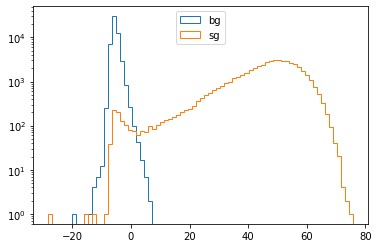

0.9791775311033301


In [9]:
# print(y_trues.shape, y_probs.shape)
nbins=76
qstat = nnouts
#qstat = np.log(1.+np.exp(nnouts))
#qstat = 1.+np.exp(nnouts)
#qstat = 1./(1 + np.exp(-nnouts))
#xrange = [0., 10.]#qstat.max()]
xrange = [qstat.min(), qstat.max()]

bg_mask = (y_trues==0)
sg_mask = (y_trues==1)

qstat_bg = qstat[bg_mask]
qstat_sg = qstat[sg_mask]

print('bg:',qstat_bg.min(), qstat_bg.max())
print('sg:',qstat_sg.min(), qstat_sg.max())
plt.hist(qstat_bg, histtype='step', bins=nbins, label='bg', range=xrange)
plt.hist(qstat_sg, histtype='step', bins=nbins, label='sg', range=xrange)
#plt.xlim([0., 10.])
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper center')
plt.show()

qstat_bg_max = qstat_bg.max()
print(len(qstat_sg[qstat_sg>qstat_bg_max])/len(qstat_sg))

In [10]:
def set_hist(h, xtitle, ytitle, htitle):
    #c.SetLeftMargin(0.16)
    #c.SetRightMargin(0.15)
    #c.SetBottomMargin(0.13)
    ROOT.gStyle.SetOptStat(0)

    h.GetXaxis().SetLabelSize(0.04)
    h.GetXaxis().SetLabelFont(42)
    h.GetXaxis().SetTitle(xtitle)
    h.GetXaxis().SetTitleOffset(0.09)
    h.GetXaxis().SetTitleSize(0.06)
    h.GetXaxis().SetTitleFont(42)

    h.GetYaxis().SetLabelSize(0.04)
    h.GetYaxis().SetLabelFont(42)
    h.GetYaxis().SetTitleOffset(1.2)
    h.GetYaxis().SetTitleSize(0.06)
    h.GetYaxis().SetTitleFont(42)
    h.GetYaxis().SetTitle(ytitle)

    h.SetTitleSize(0.04)
    h.SetTitleFont(62)
    h.SetTitle(htitle)
    h.SetTitleOffset(1.2)

    #return h, c
    return h

In [11]:
import LIGO_style
#tdrstyle.setTDRStyle()
ROOT.gStyle.SetPadTickX(1)
ROOT.gStyle.SetPadTickY(1)
#change the CMS_lumi variables (see CMS_lumi.py)
LIGO_style.writeExtraText = 1
LIGO_style.extraText = "Hanford"
LIGO_style.cmsTextOffset = 0.
#t_total = 8*4096 # s
t_total = int(0.5*len(idxs_val)/2)
t_total_h = t_total//(60*60) # h
t_total_m = (t_total%(60*60))//60 # m
t_total_s = t_total_m%(60) # s
t_total_str = '%sh%sm%ss'%(t_total_h, t_total_h, t_total_s)
LIGO_style.lumi_sqrtS = "%s (O1)"%t_total_str # used with iPeriod = 0, e.g. for simulation-only plots (default is an empty string)
#iPos = 11 # inside frame
iPos = 0 # above frame
if iPos==0: LIGO_style.relPosX = 0.16
iPeriod = 0
print(t_total_str)

7h7m29s


In [12]:
h, c, hc = {}, {}, {}
line, legend = {}, {}
nbins = 20
wd, ht = int(480*1), int(420*1)

In [13]:
edges_ = {}
#edges_[0] = np.arange(0,10,1)
edges_[0] = np.arange(0,7,1)
print(edges_[0])
#edges_[1] = np.arange(10,80+10,10)
edges_[1] = np.arange(7,77+5,5)
print(edges_[1])
edges = np.concatenate([edges_[e] for e in edges_])
edges = np.arange(0,80+1,1)
print(edges)

nbins = len(edges)-1
edges = array('d', edges)
'''
fprinv_edges = (1./fpr_edges)[::-1]
fprinv_edges[-1] = 1.e6
print(fprinv_edges)

hsg = sg_thr[::-1]
print(hsg)
hbg = bg_thr[::-1]
print(hbg)
# NOTE: in this binning, bin_val | edge_i < bin_val <= edge_i+1
# i.e. inclusive on upper edge, rather than on lower edge, so that
# (1) top bg scores are histogrammed below FPinv max
# (2) top sg scores dont go into overflow bin
nbins = len(fprinv_edges)-1
fprinv_edges = array('d', fprinv_edges)
'''

k = 'nsgvqstat'
#h[k] = ROOT.TH1F(k, k, 80, 0., 80.)
h[k] = ROOT.TH1F(k, k, nbins, edges)

k = 'nbgvqstat'
c[k] = ROOT.TCanvas('c'+k, 'c'+k, 480, 420)
#h[k] = ROOT.TH1F(k, k, 80, 0., 80.)
h[k] = ROOT.TH1F(k, k, nbins, edges)

for q in qstat_bg:
    h['nbgvqstat'].Fill(q)

for q in qstat_sg:
    h['nsgvqstat'].Fill(q)

[0 1 2 3 4 5 6]
[ 7 12 17 22 27 32 37 42 47 52 57 62 67 72 77]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80]


7h7m29s (O1)


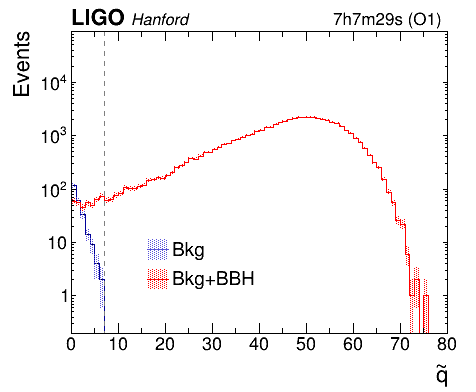

In [14]:
err_style = 'E2'
fill_style = 3002
LIGO_style.relPosX = 0.16

k = 'nbgvqstat'
c[k].cd()
#h[k] = set_hist(h[k], 'FAR^{-1}', 'Events', '')
h[k] = set_hist(h[k], '#tilde{q}', 'Events', '')
ROOT.gPad.SetTopMargin(0.08)
ROOT.gPad.SetBottomMargin(0.15)
ROOT.gPad.SetLeftMargin(0.15)
ROOT.gPad.SetRightMargin(0.06) # without colz
ROOT.TGaxis.fgMaxDigits = 3
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetErrorX(0.5)
#ROOT.gPad.SetLogx()
ROOT.gPad.SetLogy()

ymin, ymax = 2.e-1, 9.e4
h[k].GetYaxis().SetRangeUser(ymin, ymax)
h[k].GetYaxis().SetTitleOffset(1.1)
h[k].GetYaxis().SetTitleSize(0.06)
h[k].GetYaxis().SetLabelSize(0.05)
h[k].GetYaxis().SetLabelFont(42)
h[k].GetYaxis().SetTickLength(0.01)
h[k].GetYaxis().SetTitleFont(42)
h[k].GetYaxis().SetMaxDigits(3)
h[k].GetYaxis().SetNdivisions(-4)

h[k].GetXaxis().SetTitleOffset(1.1)
h[k].GetXaxis().SetTitleSize(0.06)
h[k].GetXaxis().SetLabelSize(0.05)
h[k].GetXaxis().SetLabelFont(42)
h[k].GetXaxis().SetTitleFont(42)
#h[k].GetXaxis().SetNdivisions(-405)
h[k].GetXaxis().SetNdivisions(409)
#h[k].GetXaxis().ChangeLabel(-1,-1,-1,-1,-1,-1, "10^{#infty}")
#h[k].GetXaxis().ChangeLabel(-1,-1,0,-1,-1,-1, "")

# bg, line
h[k].Draw('hist')
# bg, band
hc[k] = h[k].Clone()
hc[k].SetName(k+'band')
hc[k].SetMarkerStyle(1)
hc[k].SetMarkerSize(0)
hc[k].SetLineColor(9)
hc[k].SetFillColor(9)
hc[k].SetFillStyle(fill_style)
hc[k].Draw("%s same"%err_style)

k = 'nsgvqstat'
# sg, line
h[k].SetLineColor(2)
h[k].Draw('hist same')
# sg, band
hc[k] = h[k].Clone()
hc[k].SetName(k+'band')
hc[k].SetMarkerStyle(1)
hc[k].SetMarkerSize(0)
hc[k].SetMarkerColor(2)
hc[k].SetLineColor(2)
hc[k].SetFillColor(2)
hc[k].SetFillStyle(fill_style)
hc[k].Draw("%s same"%err_style)

k = 'nbgvqstat'
legend[k] = ROOT.TLegend(0.3, 0.25, 0.3+0.25, 0.25+0.15) #(x1, y1, x2, y2)
legend[k].AddEntry(hc['nbgvqstat'].GetName(), "Bkg",     "lf")
legend[k].AddEntry(hc['nsgvqstat'].GetName(), "Bkg+BBH", "lf")
legend[k].SetBorderSize(0)
legend[k].SetTextFont(42)
legend[k].Draw("same")

kl1 = k+'l1'
line[kl1] = ROOT.TLine(7., 0., 7., ymax) # x0,y0, x1,y1
line[kl1].SetLineColor(14)
line[kl1].SetLineStyle(7)
line[kl1].Draw("same")

#kl2 = k+'l2'
#line[kl2] = ROOT.TLine(fprinv_max, 0., fprinv_max, ymax) # x0,y0, x1,y1
#line[kl2].SetLineColor(14)
#line[kl2].SetLineStyle(7)
#line[kl2].Draw("same")

c[k].RedrawAxis()
c[k].Draw()

LIGO_style.LIGO_style(c[k], iPeriod, iPos)

In [19]:
wd, ht = int(480*1), int(400*1)

#thr_fprinv_glitch = thr_coarse[-5] #0.96222246

k = 'sgeffqstat'
c[k] = ROOT.TCanvas('c'+k, 'c'+k, wd, ht)
h[k] = ROOT.TProfile2D('h'+k, 'h'+k, 10, 100, 500, 10, 40, 100)
dists_sg = dists[sg_mask]
#mtots_sg = mtots[sg_mask]
mtots_sg = (m1s+m2s)[sg_mask]

#y_probs_sg = y_probs[sg_mask]
for i in range(len(mtots_sg)):
    # top k
    #h[k].Fill(dists_sg[i], mtots_sg[i], 1. if qstat_sg[i] >= 50. else 0.)
    #h[k].Fill(dists_sg[i], mtots_sg[i], 1. if (qstat_sg[i] < 50. and qstat_sg[i] > qstat_bg_max) else 0.)
    # high-purity regime
    h[k].Fill(dists_sg[i], mtots_sg[i], 1. if qstat_sg[i] > qstat_bg_max else 0.)
    # glitch regime
    #h[k].Fill(dists_sg[i], mtots_sg[i], 1. if (qstat_sg[i] < qstat_bg_max and qstat_sg[i] >= 1.) else 0.)
    # nois regime
    #h[k].Fill(dists_sg[i], mtots_sg[i], 1. if qstat_sg[i] < 1. else 0.)

print(h[k].GetMinimum(), h[k].GetMaximum())

0.7787610619469026 1.0


Warning in <TCanvas::Constructor>: Deleting canvas with same name: csgeffqstat
Warning in <TROOT::Append>: Replacing existing TH1: hsgeffqstat (Potential memory leak).


7h7m29s (O1)


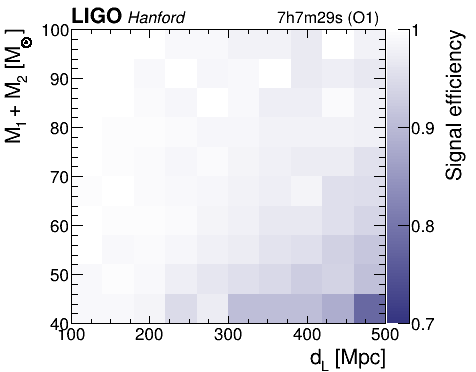

In [59]:
if iPos==0: LIGO_style.relPosX = 0.18

k = 'sgeffqstat'

c[k].cd()
h[k] = set_hist(h[k], 'd_{L} [Mpc]', 'M_{1} + M_{2} [M_{#odot} ]', '')
ROOT.gPad.SetTopMargin(0.08)
ROOT.gPad.SetBottomMargin(0.13)
ROOT.gPad.SetLeftMargin(0.15)
ROOT.gPad.SetRightMargin(0.19) # with colz
#ROOT.gPad.SetRightMargin(0.1) # without colz
ROOT.TGaxis.fgMaxDigits = 3
ROOT.gStyle.SetOptStat(0)
ROOT.gPad.SetLogz(0) #0:set False, 1:set True

ymin, ymax = 40., 100.
h[k].GetYaxis().SetRangeUser(ymin, ymax)
h[k].GetYaxis().SetTitleOffset(1.2)
h[k].GetYaxis().SetTitleSize(0.06)
h[k].GetYaxis().SetLabelSize(0.05)
h[k].GetYaxis().SetLabelFont(42)
h[k].GetYaxis().SetTitleFont(42)
#h[k].GetYaxis().ChangeLabel(1,-1,0,-1,-1,-1, "")

h[k].GetXaxis().SetTitleOffset(1.0)
h[k].GetXaxis().SetTitleSize(0.06)
h[k].GetXaxis().SetLabelSize(0.05)
h[k].GetXaxis().SetLabelFont(42)
h[k].GetXaxis().SetTitleFont(42)
h[k].GetXaxis().SetNdivisions(-404)

h[k].GetZaxis().SetTitle('Signal efficiency')
h[k].GetZaxis().SetTitleOffset(1.)
h[k].GetZaxis().SetTitleSize(0.06)
h[k].GetZaxis().SetLabelSize(0.05)
h[k].GetZaxis().SetTitleFont(42)
h[k].GetZaxis().SetLabelFont(42)
h[k].GetZaxis().SetNdivisions(-3)

# Use built-in palette
ROOT.gStyle.SetPalette(51)#53:kDarkBodyRadiator, 51:kDeepSea, 52:Gray
# Create custom palette
# Based on palette in https://arxiv.org/pdf/1407.0558.pdf
npts = 3
reds = [1., 151./255., 50./255.]
grns = [1., 151./255., 50./255.]
blus = [1., 193./255., 0.5]
#reds = [1., 138./255., 20./255.]
#grns = [1., 138./255., 20./255.]
#blus = [1., 172./255., 90./255.]
reds = array('d', reds)
grns = array('d', grns)
blus = array('d', blus)
lens = [0., 0.5, 1.]
lens = array('d', lens)
nconts = 100
ROOT.TColor.CreateGradientColorTable(npts, lens, reds, grns, blus, nconts)
# To save, but doesnt seem to work
#palette0 = ROOT.TColor.CreateGradientColorTable(npts, lens, reds, grns, blus, nconts)
#custom_palette = np.array([palette0+i for i in range(nconts)])
#custom_palette = array('d', custom_palette)

# Invert palette
ROOT.TColor.InvertPalette()

h[k].SetMaximum(1.)
h[k].SetMinimum(0.7)
h[k].SetContour(100)
h[k].Draw('COLZ')

c[k].Draw()

LIGO_style.LIGO_style(c[k], iPeriod, iPos)

In [60]:
wd, ht = int(480*1), int(400*1)

#thr_fprinv_glitch = thr_coarse[-5] #0.96222246

k = 'decraFPRinvmax'
c[k] = ROOT.TCanvas('c'+k, 'c'+k, wd, ht)
h[k] = ROOT.TProfile2D('h'+k, 'h'+k, 10, 0, 2*np.pi, 20, -np.pi/2., np.pi/2)
decs_sg = decs[sg_mask]
ras_sg = ras[sg_mask]
#y_probs_sg = y_probs[sg_mask]
for i in range(len(decs_sg)):
    
    dec_ = decs_sg[i] if decs_sg[i] < np.pi/2. else decs_sg[i] - np.pi
    # top k
    #h[k].Fill(ras_sg[i], dec_, 1. if qstat_sg[i] >= 50. else 0.)
    #h[k].Fill(ras_sg[i], dec_, 1. if (qstat_sg[i] < 50. and qstat_sg[i] > qstat_bg_max) else 0.)
    # high-purity regime
    h[k].Fill(ras_sg[i], dec_, 1. if qstat_sg[i] > qstat_bg_max else 0.)
    # glitch regime
    #h[k].Fill(ras_sg[i], dec_, 1. if (qstat_sg[i] < qstat_bg_max and qstat_sg[i] >= 1.) else 0.)
    # nois regime
    #h[k].Fill(ras_sg[i], dec_, 1. if qstat_sg[i] < 1. else 0.)

print(h[k].GetMinimum(), h[k].GetMaximum())

0.8687943262411347 1.0


Warning in <TCanvas::Constructor>: Deleting canvas with same name: cdecraFPRinvmax
Warning in <TROOT::Append>: Replacing existing TH1: hdecraFPRinvmax (Potential memory leak).


7h7m29s (O1)


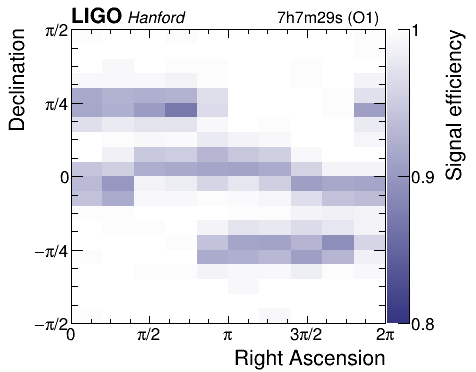

In [61]:
if iPos==0: LIGO_style.relPosX = 0.18

k = 'decraFPRinvmax'

c[k].cd()
h[k] = set_hist(h[k], 'Right Ascension', 'Declination', '')
ROOT.gPad.SetTopMargin(0.08)
ROOT.gPad.SetBottomMargin(0.13)
ROOT.gPad.SetLeftMargin(0.15)
ROOT.gPad.SetRightMargin(0.19) # with colz
#ROOT.gPad.SetRightMargin(0.1) # without colz
ROOT.TGaxis.fgMaxDigits = 3
ROOT.gStyle.SetOptStat(0)
ROOT.gPad.SetLogz(0) #0:set False, 1:set True

ymin, ymax = 40., 100.
#h[k].GetYaxis().SetRangeUser(ymin, ymax)
h[k].GetYaxis().SetTitleOffset(1.2)
h[k].GetYaxis().SetTitleSize(0.06)
h[k].GetYaxis().SetLabelSize(0.05)
h[k].GetYaxis().SetLabelFont(42)
h[k].GetYaxis().SetTitleFont(42)
h[k].GetYaxis().SetNdivisions(-404)
h[k].GetYaxis().ChangeLabel(1,-1,-1,-1,-1,-1, "-#pi/2")
h[k].GetYaxis().ChangeLabel(2,-1,-1,-1,-1,-1, "-#pi/4")
h[k].GetYaxis().ChangeLabel(3,-1,-1,-1,-1,-1, "0")
h[k].GetYaxis().ChangeLabel(4,-1,-1,-1,-1,-1, "#pi/4")
h[k].GetYaxis().ChangeLabel(5,-1,-1,-1,-1,-1, "#pi/2")

h[k].GetXaxis().SetTitleOffset(1.0)
h[k].GetXaxis().SetTitleSize(0.06)
h[k].GetXaxis().SetLabelSize(0.05)
h[k].GetXaxis().SetLabelFont(42)
h[k].GetXaxis().SetTitleFont(42)
h[k].GetXaxis().SetNdivisions(-404)
h[k].GetXaxis().ChangeLabel(1,-1,-1,-1,-1,-1, "0")
h[k].GetXaxis().ChangeLabel(2,-1,-1,-1,-1,-1, "#pi/2")
h[k].GetXaxis().ChangeLabel(3,-1,-1,-1,-1,-1, "#pi")
h[k].GetXaxis().ChangeLabel(-2,-1,-1,-1,-1,-1, "3#pi/2")
h[k].GetXaxis().ChangeLabel(-1,-1,-1,-1,-1,-1, "2#pi")

h[k].GetZaxis().SetTitle('Signal efficiency')
h[k].GetZaxis().SetTitleOffset(1.)
h[k].GetZaxis().SetTitleSize(0.06)
h[k].GetZaxis().SetLabelSize(0.05)
h[k].GetZaxis().SetTitleFont(42)
h[k].GetZaxis().SetLabelFont(42)
h[k].GetZaxis().SetNdivisions(-2)

h[k].SetMaximum(1.)
h[k].SetMinimum(0.8)

# Use built-in palette
ROOT.gStyle.SetPalette(51)#53:kDarkBodyRadiator, 51:kDeepSea, 52:Gray
# Create custom palette
# Based on palette in https://arxiv.org/pdf/1407.0558.pdf
npts = 3
reds = [1., 151./255., 50./255.]
grns = [1., 151./255., 50./255.]
blus = [1., 193./255., 0.5]
#reds = [1., 138./255., 20./255.]
#grns = [1., 138./255., 20./255.]
#blus = [1., 172./255., 90./255.]
reds = array('d', reds)
grns = array('d', grns)
blus = array('d', blus)
lens = [0., 0.5, 1.]
lens = array('d', lens)
nconts = 100
ROOT.TColor.CreateGradientColorTable(npts, lens, reds, grns, blus, nconts)
# To save, but doesnt seem to work
#palette0 = ROOT.TColor.CreateGradientColorTable(npts, lens, reds, grns, blus, nconts)
#custom_palette = np.array([palette0+i for i in range(nconts)])
#custom_palette = array('d', custom_palette)

# Invert palette
ROOT.TColor.InvertPalette()

h[k].SetContour(100)
h[k].Draw('COLZ')

c[k].Draw()
c[k].Update()

LIGO_style.LIGO_style(c[k], iPeriod, iPos)